**Table of contents**

- Introduction
- Step 1: Answering the question
- Step 2: Checking the data
- Step 3: Feature engineering
- Step 4: Cleaning the data
- Step 5: Exploratory analysis
- Step 6: Classifier testing
- Step 7: Classification


**Introduction**

Band data will be used to predict the urban land cover label (trees, grass, water, buildings, impervious surface) of pixels of Worldview-3 satellite images. 

The training dataset contains:
- Band data in the first 8 columns. 
- Coordinates (x, y) in column 9 and 10.
- The label variable is saved in column 11.

**Step 1: Answering the question**


*Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?*

We're trying to classify the land cover type/class (trees, grass, water, buildings, impervious surface) of urban parks based on a pixel-based training dataset that includes around 200 pixels per land cover type.


*Did you define the metric for success before beginning?*

Let's do that now. Since we're performing classification, we can use accuracy — the fraction of correctly classified pixels — to quantify how well our model is performing. We aim to achieve at least 90% accuracy.


*Did you understand the context for the question and the scientific or business application?*

We're building an image classification model that's specialized in classifying the land cover type of urban parks. 


*Did you record the experimental design?*

We created the experimental design ourselves. Worldview-3 satellite images were used to create the trainingdataset. Per chunk of approximately 400x400m 5 pixels per label were selected by clicking. 


*Did you consider whether the question could be answered with the available data?*

The data set we currently have is based on only one satellite image. The model build of this data set will only work for satellite images with similar properties. Therefore we need more data the create a general image classifier. 

**Installing packages**

Before we start we need to install the following packages: sklearn and seaborn.
Copy the following commands in the terminal:
- pip install sklearn
- pip install seaborn
- pip install xgboost
- pip install folium

**Step 2: Checking the data**

In [8]:
# Reading the raw data into a Pandas DataFrame

import pandas as pd

data_raw = pd.read_csv('data_Jakarta_Situ_Babakan.csv')
data_raw.head()

0       1       2       3       4       5       6       7    x    y  \
0  1830.0  1589.0  1437.0  1258.0  1122.0  1884.0  3022.0  2536.0  102  147   
1  1852.0  1619.0  1434.0  1300.0  1222.0  1654.0  2371.0  2046.0   70  128   
2  1849.0  1657.0  1472.0  1391.0  1411.0  1735.0  2344.0  2065.0   76  116   
3  1804.0  1535.0  1367.0  1140.0  1102.0  1474.0  1983.0  1602.0   80   83   
4  1810.0  1556.0  1341.0  1201.0  1064.0  1612.0  2331.0  1982.0   63   49   

       label  
0  non_water  
1  non_water  
2  non_water  
3  non_water  
4  non_water

In [9]:
# Print out summary statistics about the data set

data_raw.describe()

0            1            2            3           4  \
count   140.000000   140.000000   140.000000   140.000000   140.00000   
mean   1837.085714  1629.600000  1499.978571  1418.928571  1351.05000   
std     106.527700   165.053198   221.843047   283.566130   345.47018   
min    1647.000000  1369.000000  1183.000000   989.000000   891.00000   
25%    1770.500000  1531.750000  1365.500000  1228.750000  1106.75000   
50%    1824.000000  1606.500000  1455.500000  1344.500000  1239.50000   
75%    1878.000000  1661.500000  1558.000000  1578.000000  1500.00000   
max    2225.000000  2464.000000  2510.000000  2925.000000  3046.00000   

                 5            6            7           x           y  
count   140.000000   140.000000   140.000000  140.000000  140.000000  
mean   1586.321429  1893.057143  1542.878571  322.792857  330.364286  
std     327.799207   583.954822   529.729081  159.979742  169.302769  
min    1056.000000  1048.000000   790.000000   26.000000   19.000000  
25%    1330.500000  1322.500000   970.750000  186.000000  186.500000  
50%    1525.000000  1872.000000  1574.500000  313.500000  348.000000  
75%    1827.000000  2245.250000  1918.750000  454.750000  480.500000  
max    3452.000000  3815.000000  2894.000000  595.000000  597.000000

In [10]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb                 # If error: pip install seaborn in terminal

''

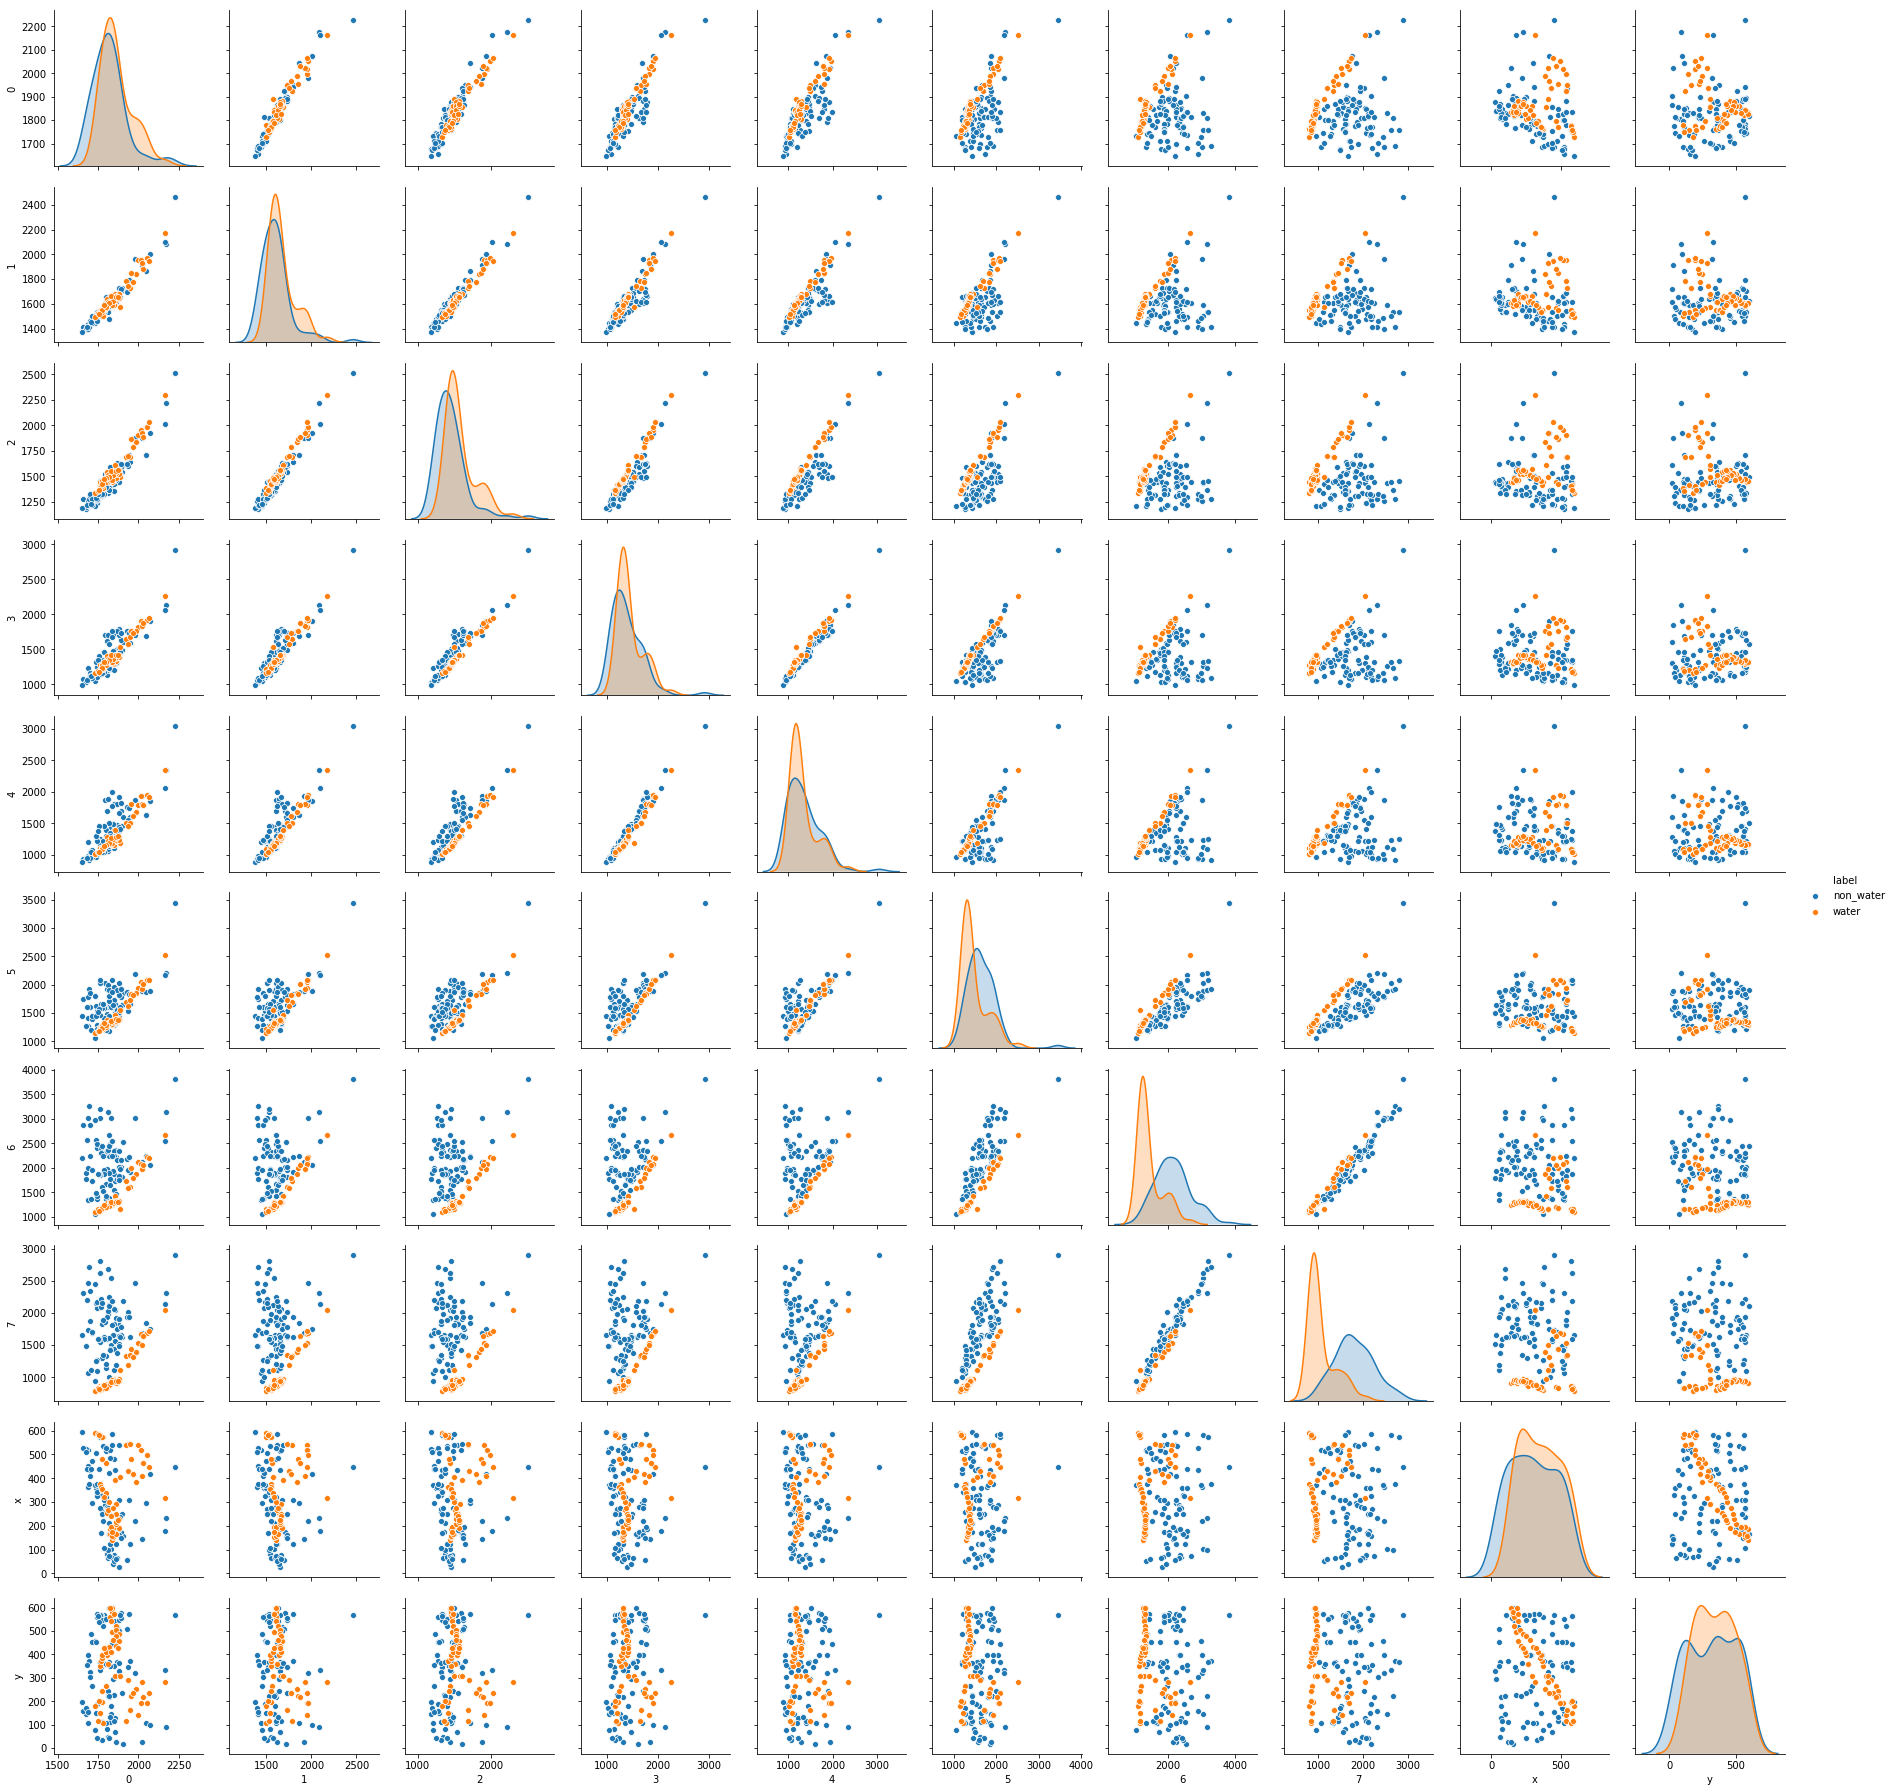

In [11]:
# Create scatterplot matrix to visualize errors
sb.pairplot(data_raw.dropna(), hue='label')
;

**Step 3: Feature engineering**

There are still some predictors we want to add to our dataset. We'll calculate indices that will help us to distinguish even better between the different land cover classes. We will use the following indices:

**NDVI** =	Normalized Differnce Vegetation Index   
**NDWI** =	Normalised Difference Water Index  
**NDBI** =   Normalized Difference Built-Up Index   
**II** = Iron Index

[Source](https://notebooks.geobigdata.io/hub/notebooks/5a3ad6989b604e2ff535c27b?tab=code)

We will use the band data that we have to calculate the indices. The first 8 columns of our dataset correspond to the following bands:
- 0 = coastal
- 1 = blue
- 2 = green
- 3 = yellow
- 4 = red
- 5 = red_edge
- 6 = nir1
- 7 = nir2

In [12]:
# First we rename the columns of our dataset 

data_raw.columns = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2','x','y','label']
data_raw.head()

coastal    blue   green  yellow     red  red_edge    nir1    nir2    x  \
0   1830.0  1589.0  1437.0  1258.0  1122.0    1884.0  3022.0  2536.0  102   
1   1852.0  1619.0  1434.0  1300.0  1222.0    1654.0  2371.0  2046.0   70   
2   1849.0  1657.0  1472.0  1391.0  1411.0    1735.0  2344.0  2065.0   76   
3   1804.0  1535.0  1367.0  1140.0  1102.0    1474.0  1983.0  1602.0   80   
4   1810.0  1556.0  1341.0  1201.0  1064.0    1612.0  2331.0  1982.0   63   

     y      label  
0  147  non_water  
1  128  non_water  
2  116  non_water  
3   83  non_water  
4   49  non_water

In [13]:
# Here we will calculate the indices with the band data we already have

data_raw['ndvi'] = (data_raw.nir1 - data_raw.red)/(data_raw.nir1 + data_raw.red)
data_raw['ndwi'] = (data_raw.green - data_raw.nir1)/(data_raw.green + data_raw.nir1)


data_raw.head()

coastal    blue   green  yellow     red  red_edge    nir1    nir2    x  \
0   1830.0  1589.0  1437.0  1258.0  1122.0    1884.0  3022.0  2536.0  102   
1   1852.0  1619.0  1434.0  1300.0  1222.0    1654.0  2371.0  2046.0   70   
2   1849.0  1657.0  1472.0  1391.0  1411.0    1735.0  2344.0  2065.0   76   
3   1804.0  1535.0  1367.0  1140.0  1102.0    1474.0  1983.0  1602.0   80   
4   1810.0  1556.0  1341.0  1201.0  1064.0    1612.0  2331.0  1982.0   63   

     y      label      ndvi      ndwi  
0  147  non_water  0.458494 -0.355461  
1  128  non_water  0.319788 -0.246255  
2  116  non_water  0.248469 -0.228512  
3   83  non_water  0.285575 -0.183881  
4   49  non_water  0.373196 -0.269608

**Step 4: Cleaning the data**

From the scatterplot matrix, we can conclude that we still need to clean the data:

1. Remove duplicates.
2. Remove click errors.
3. Remove outliers.
4. Remove coordinate data (these data can't be used as predictors).

In [14]:
# 1. Remove duplicates from dataset
# (these pixels were clicked when a label didn't occur in the chunk)

data_clean1 = data_raw.drop_duplicates(subset=['x', 'y'], keep= False)
data_clean1.describe()

coastal         blue        green       yellow         red  \
count   140.000000   140.000000   140.000000   140.000000   140.00000   
mean   1837.085714  1629.600000  1499.978571  1418.928571  1351.05000   
std     106.527700   165.053198   221.843047   283.566130   345.47018   
min    1647.000000  1369.000000  1183.000000   989.000000   891.00000   
25%    1770.500000  1531.750000  1365.500000  1228.750000  1106.75000   
50%    1824.000000  1606.500000  1455.500000  1344.500000  1239.50000   
75%    1878.000000  1661.500000  1558.000000  1578.000000  1500.00000   
max    2225.000000  2464.000000  2510.000000  2925.000000  3046.00000   

          red_edge         nir1         nir2           x           y  \
count   140.000000   140.000000   140.000000  140.000000  140.000000   
mean   1586.321429  1893.057143  1542.878571  322.792857  330.364286   
std     327.799207   583.954822   529.729081  159.979742  169.302769   
min    1056.000000  1048.000000   790.000000   26.000000   19.000000   
25%    1330.500000  1322.500000   970.750000  186.000000  186.500000   
50%    1525.000000  1872.000000  1574.500000  313.500000  348.000000   
75%    1827.000000  2245.250000  1918.750000  454.750000  480.500000   
max    3452.000000  3815.000000  2894.000000  595.000000  597.000000   

             ndvi        ndwi  
count  140.000000  140.000000  
mean     0.153131   -0.095087  
std      0.148351    0.150282  
min     -0.007225   -0.438049  
25%      0.044292   -0.212776  
50%      0.095118   -0.076345  
75%      0.241465    0.063502  
max      0.560057    0.123781

In [15]:
# 2. Remove click errors
# data_clean2a = data_clean1[data_clean1.x != 246]
# data_clean2b = data_clean1[data_clean1.x != 126]
#data_clean2c = data_clean1[data_clean1.x != 208]
#data_clean2d = data_clean1[data_clean1.x != 200]
#data_clean2e = data_clean1[data_clean1.x != 242]
data_clean2 = data_clean1
data_clean2.describe()

coastal         blue        green       yellow         red  \
count   140.000000   140.000000   140.000000   140.000000   140.00000   
mean   1837.085714  1629.600000  1499.978571  1418.928571  1351.05000   
std     106.527700   165.053198   221.843047   283.566130   345.47018   
min    1647.000000  1369.000000  1183.000000   989.000000   891.00000   
25%    1770.500000  1531.750000  1365.500000  1228.750000  1106.75000   
50%    1824.000000  1606.500000  1455.500000  1344.500000  1239.50000   
75%    1878.000000  1661.500000  1558.000000  1578.000000  1500.00000   
max    2225.000000  2464.000000  2510.000000  2925.000000  3046.00000   

          red_edge         nir1         nir2           x           y  \
count   140.000000   140.000000   140.000000  140.000000  140.000000   
mean   1586.321429  1893.057143  1542.878571  322.792857  330.364286   
std     327.799207   583.954822   529.729081  159.979742  169.302769   
min    1056.000000  1048.000000   790.000000   26.000000   19.000000   
25%    1330.500000  1322.500000   970.750000  186.000000  186.500000   
50%    1525.000000  1872.000000  1574.500000  313.500000  348.000000   
75%    1827.000000  2245.250000  1918.750000  454.750000  480.500000   
max    3452.000000  3815.000000  2894.000000  595.000000  597.000000   

             ndvi        ndwi  
count  140.000000  140.000000  
mean     0.153131   -0.095087  
std      0.148351    0.150282  
min     -0.007225   -0.438049  
25%      0.044292   -0.212776  
50%      0.095118   -0.076345  
75%      0.241465    0.063502  
max      0.560057    0.123781

In [16]:
# 3. Remove outliers
outlier = ((data_clean2.ndvi < 0.5) & (data_clean2['label'] == 'tree'))
data_clean3 = data_clean2[[not i for i in outlier]]
data_clean3.describe()

coastal         blue        green       yellow         red  \
count   140.000000   140.000000   140.000000   140.000000   140.00000   
mean   1837.085714  1629.600000  1499.978571  1418.928571  1351.05000   
std     106.527700   165.053198   221.843047   283.566130   345.47018   
min    1647.000000  1369.000000  1183.000000   989.000000   891.00000   
25%    1770.500000  1531.750000  1365.500000  1228.750000  1106.75000   
50%    1824.000000  1606.500000  1455.500000  1344.500000  1239.50000   
75%    1878.000000  1661.500000  1558.000000  1578.000000  1500.00000   
max    2225.000000  2464.000000  2510.000000  2925.000000  3046.00000   

          red_edge         nir1         nir2           x           y  \
count   140.000000   140.000000   140.000000  140.000000  140.000000   
mean   1586.321429  1893.057143  1542.878571  322.792857  330.364286   
std     327.799207   583.954822   529.729081  159.979742  169.302769   
min    1056.000000  1048.000000   790.000000   26.000000   19.000000   
25%    1330.500000  1322.500000   970.750000  186.000000  186.500000   
50%    1525.000000  1872.000000  1574.500000  313.500000  348.000000   
75%    1827.000000  2245.250000  1918.750000  454.750000  480.500000   
max    3452.000000  3815.000000  2894.000000  595.000000  597.000000   

             ndvi        ndwi  
count  140.000000  140.000000  
mean     0.153131   -0.095087  
std      0.148351    0.150282  
min     -0.007225   -0.438049  
25%      0.044292   -0.212776  
50%      0.095118   -0.076345  
75%      0.241465    0.063502  
max      0.560057    0.123781

In [17]:
# 4. Remove coordinate values from dataset
# these variables can't be used to predict the land cover type
data_clean4 = data_clean3.drop(columns=['x','y'])
data_clean4.describe()

coastal         blue        green       yellow         red  \
count   140.000000   140.000000   140.000000   140.000000   140.00000   
mean   1837.085714  1629.600000  1499.978571  1418.928571  1351.05000   
std     106.527700   165.053198   221.843047   283.566130   345.47018   
min    1647.000000  1369.000000  1183.000000   989.000000   891.00000   
25%    1770.500000  1531.750000  1365.500000  1228.750000  1106.75000   
50%    1824.000000  1606.500000  1455.500000  1344.500000  1239.50000   
75%    1878.000000  1661.500000  1558.000000  1578.000000  1500.00000   
max    2225.000000  2464.000000  2510.000000  2925.000000  3046.00000   

          red_edge         nir1         nir2        ndvi        ndwi  
count   140.000000   140.000000   140.000000  140.000000  140.000000  
mean   1586.321429  1893.057143  1542.878571    0.153131   -0.095087  
std     327.799207   583.954822   529.729081    0.148351    0.150282  
min    1056.000000  1048.000000   790.000000   -0.007225   -0.438049  
25%    1330.500000  1322.500000   970.750000    0.044292   -0.212776  
50%    1525.000000  1872.000000  1574.500000    0.095118   -0.076345  
75%    1827.000000  2245.250000  1918.750000    0.241465    0.063502  
max    3452.000000  3815.000000  2894.000000    0.560057    0.123781

In [18]:
data_clean = data_clean4

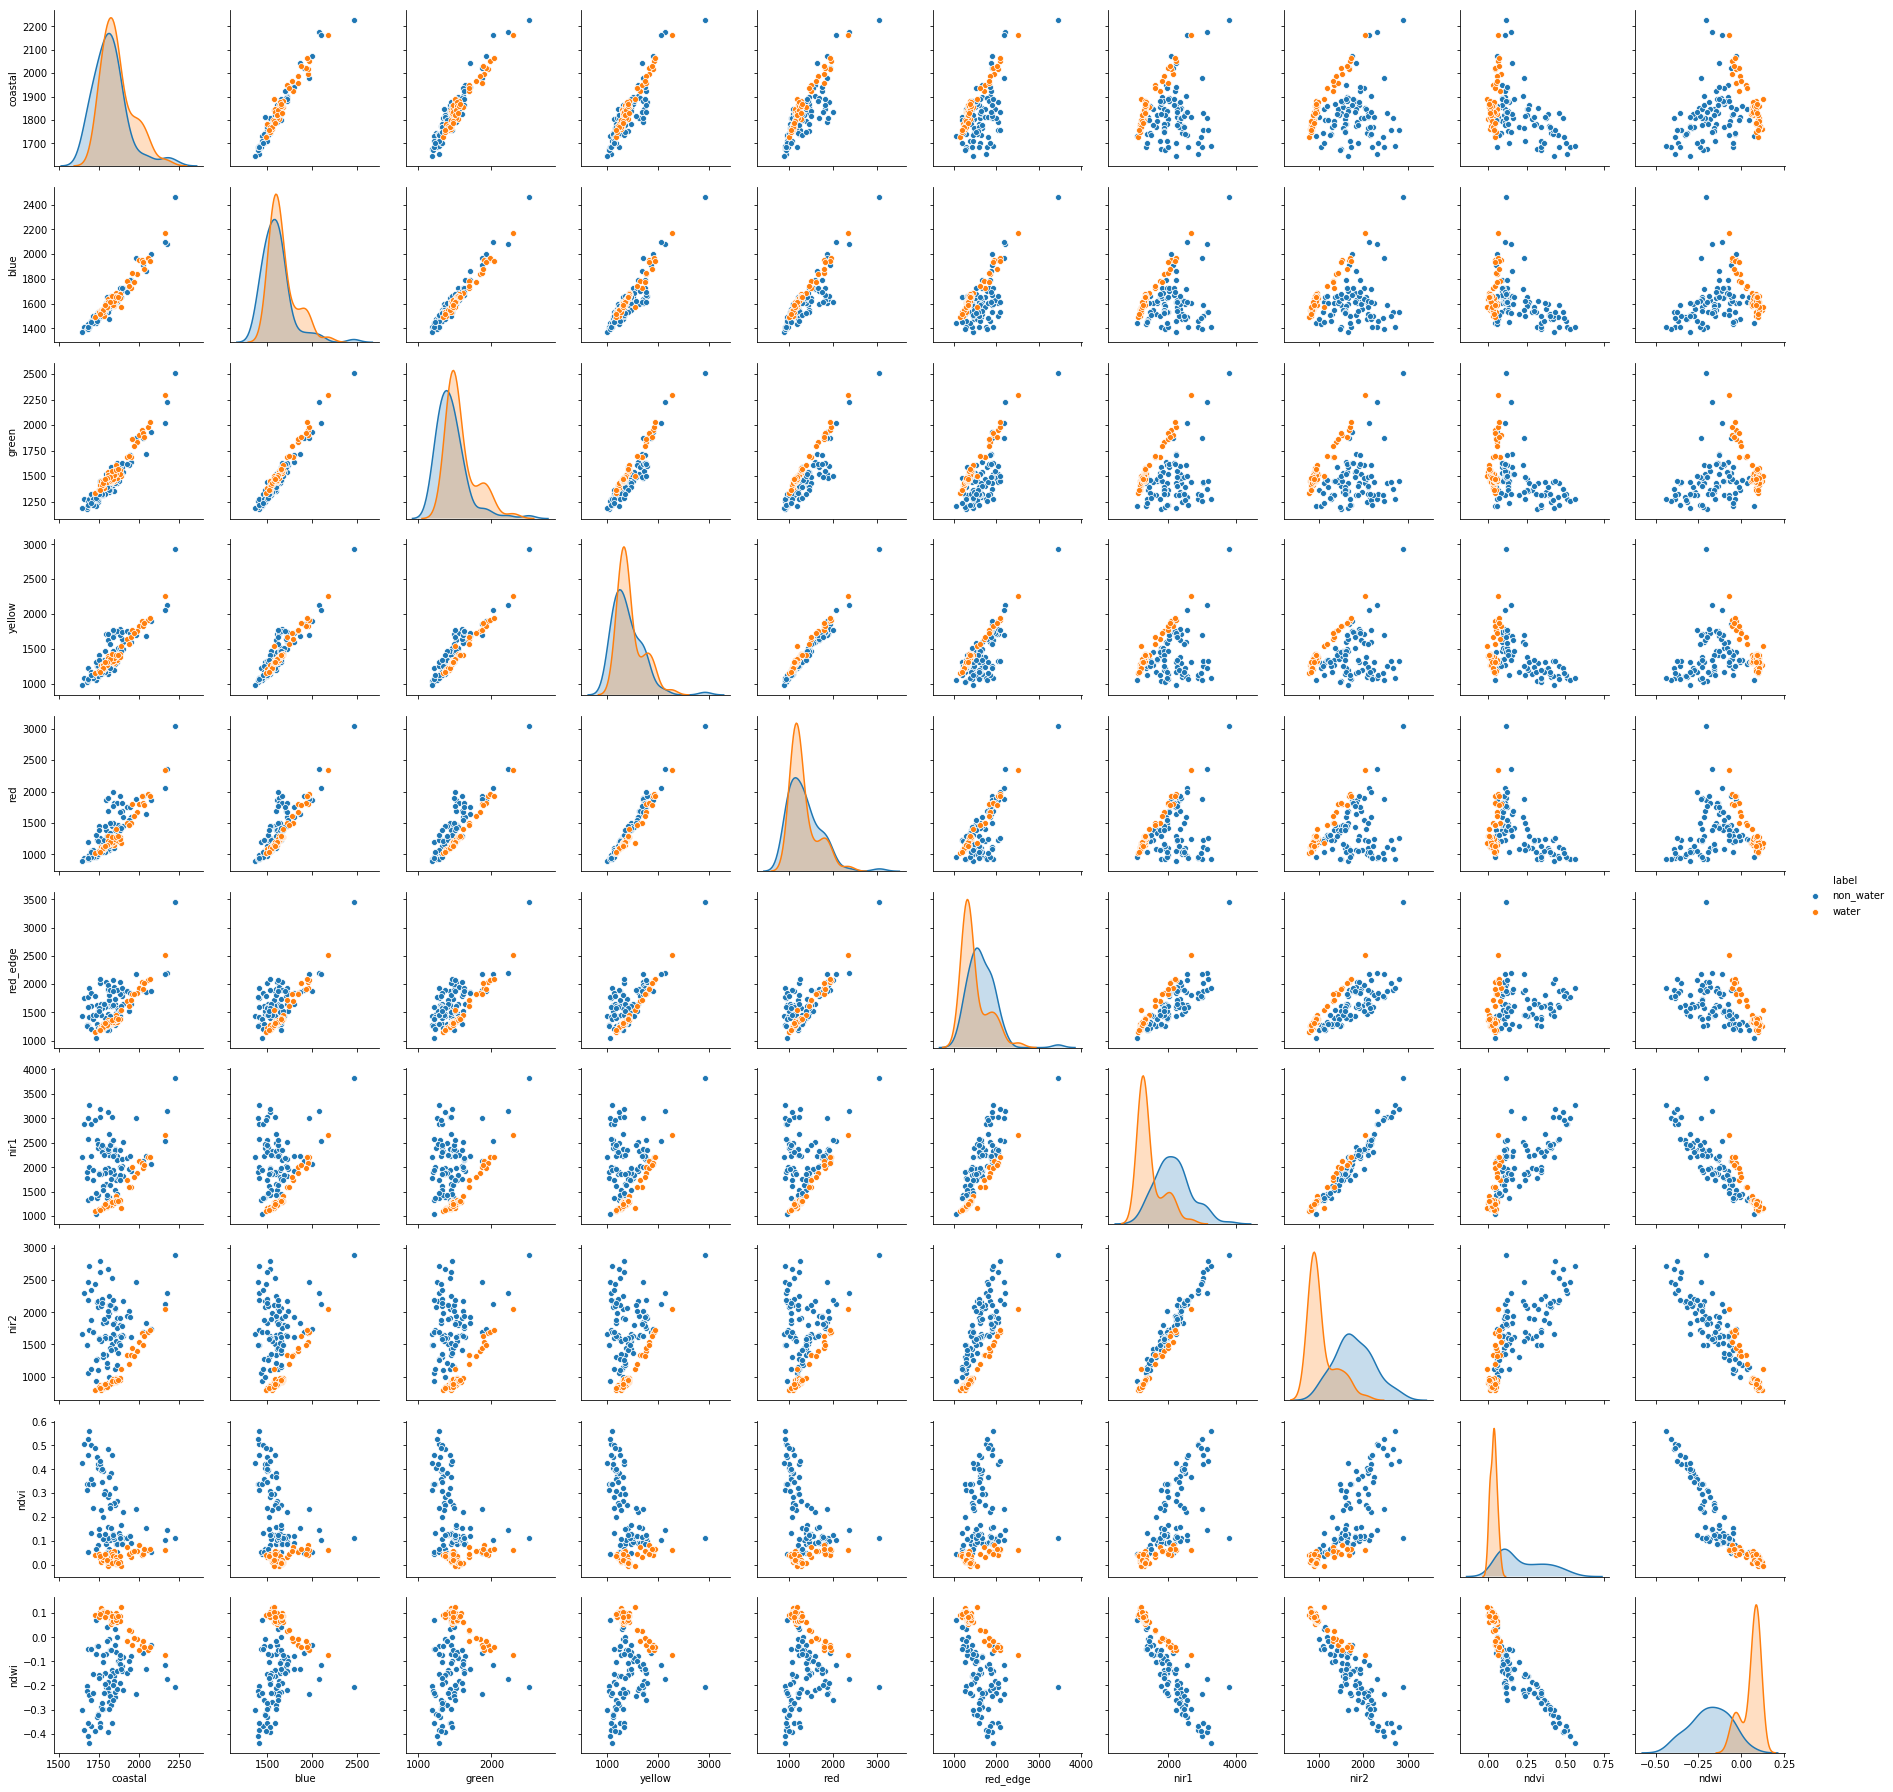

In [19]:
sb.pairplot(data_clean, hue='label')
plt.show()

**Step 5: Exploratory analysis**

In this part we start the analysis. We check how the data is distributed, if there are any correlations and if there are confounding variables.

''

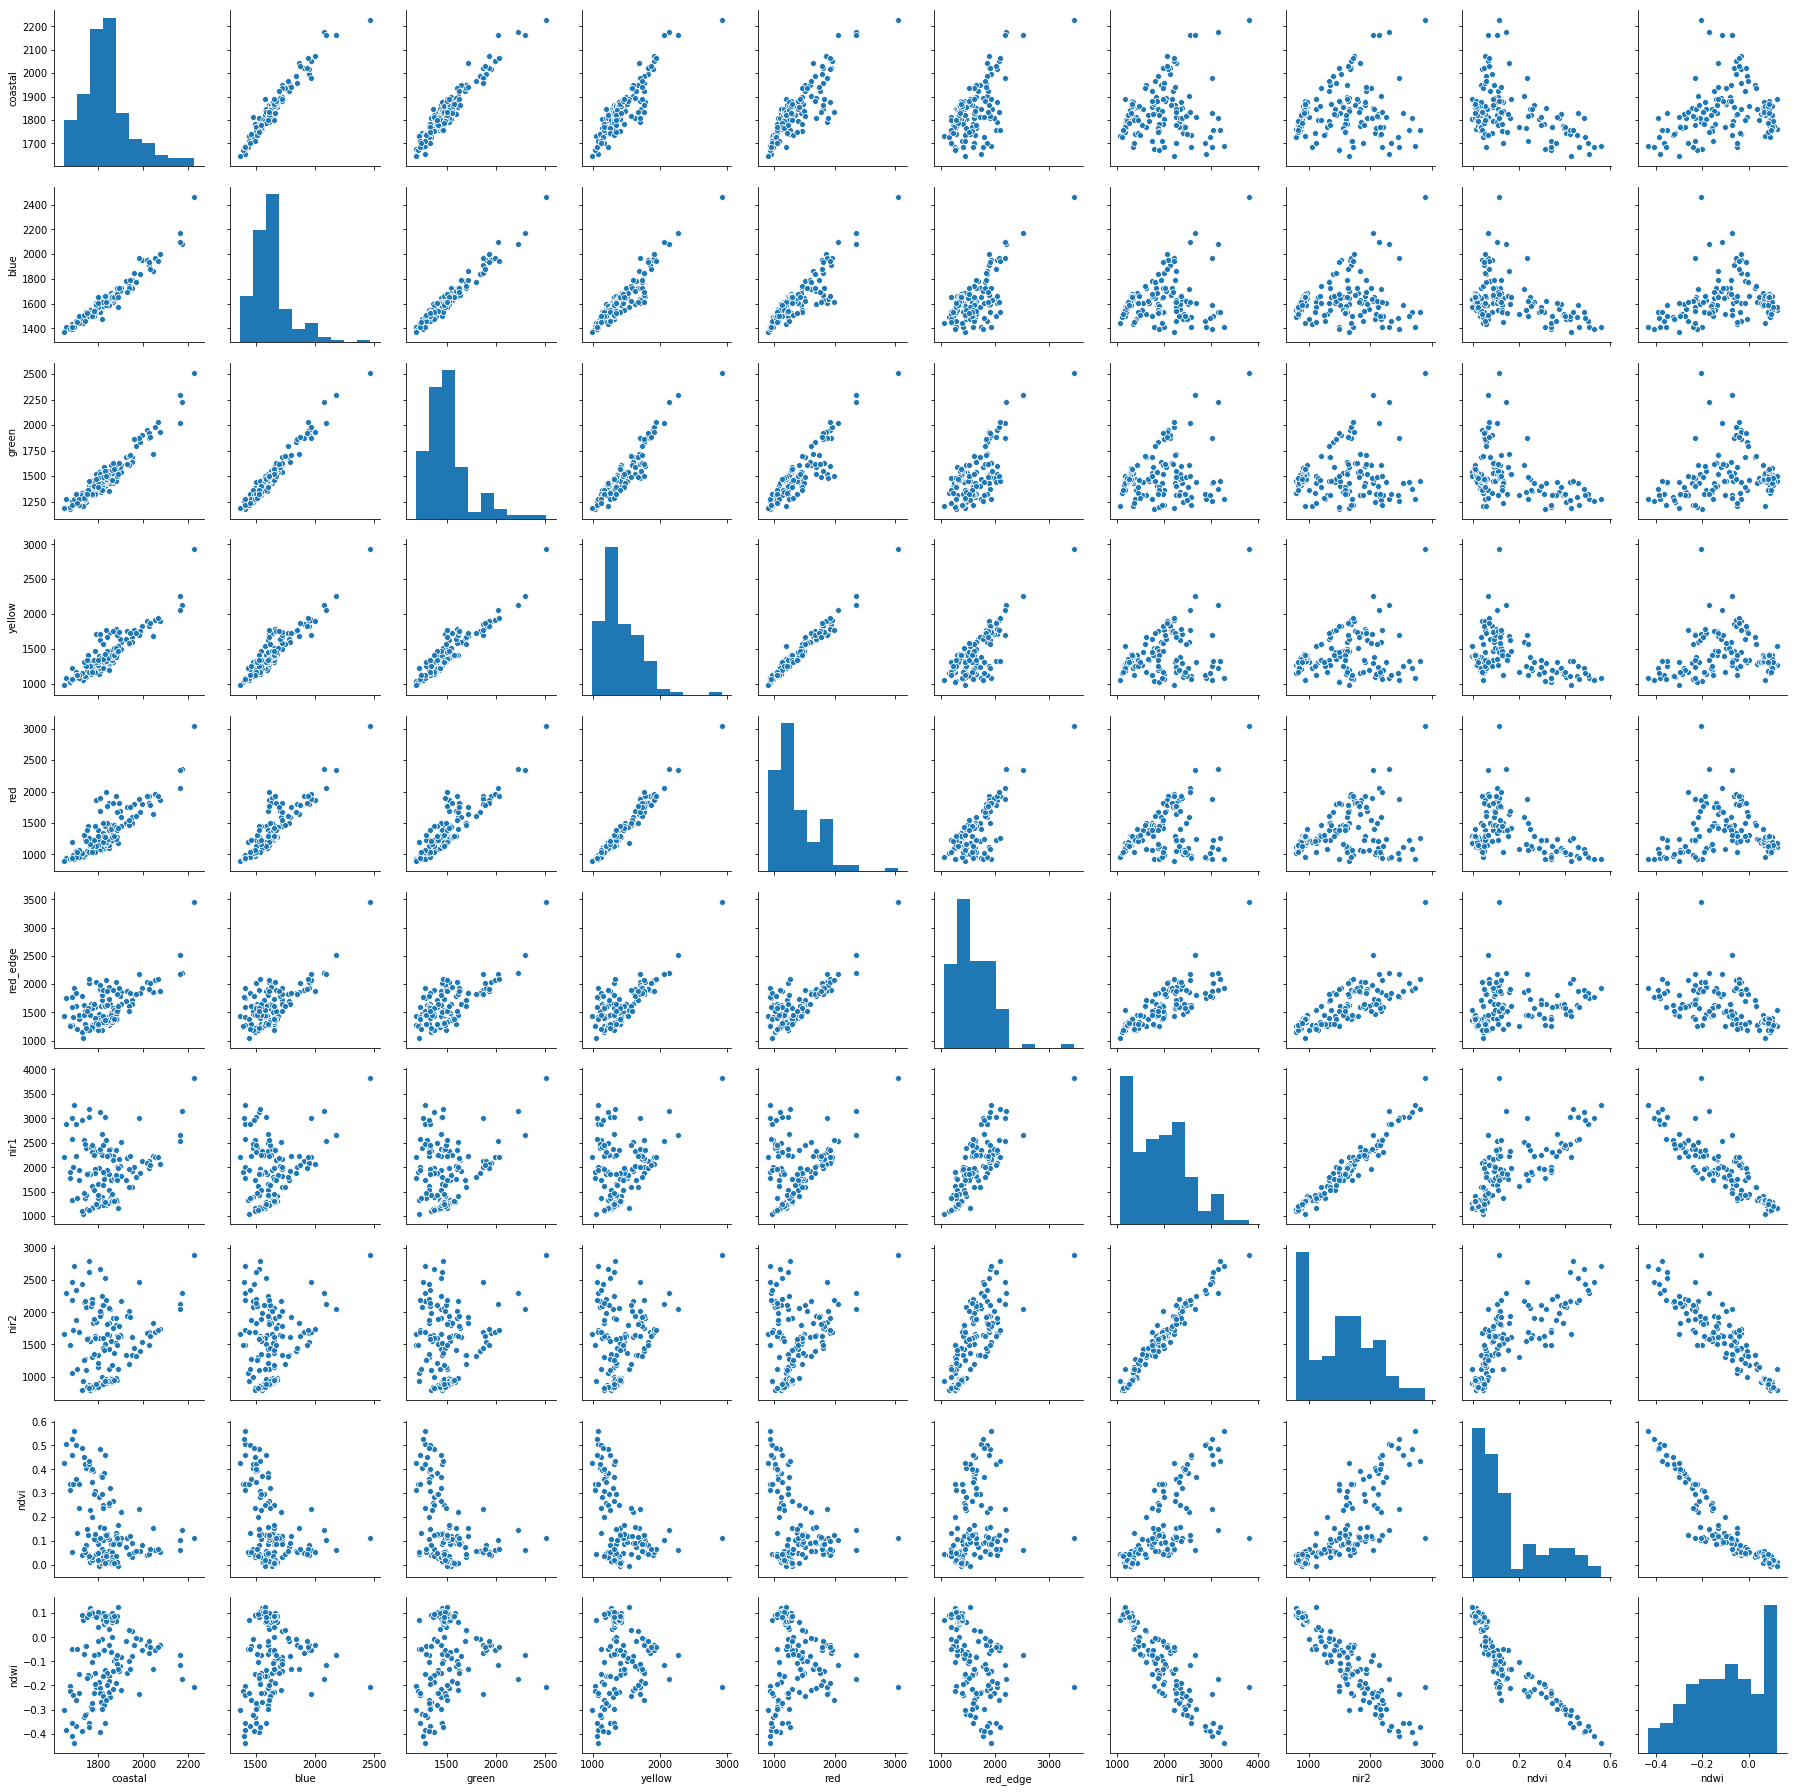

In [20]:
# Create simple scatterplot

sb.pairplot(data_clean)
;

''

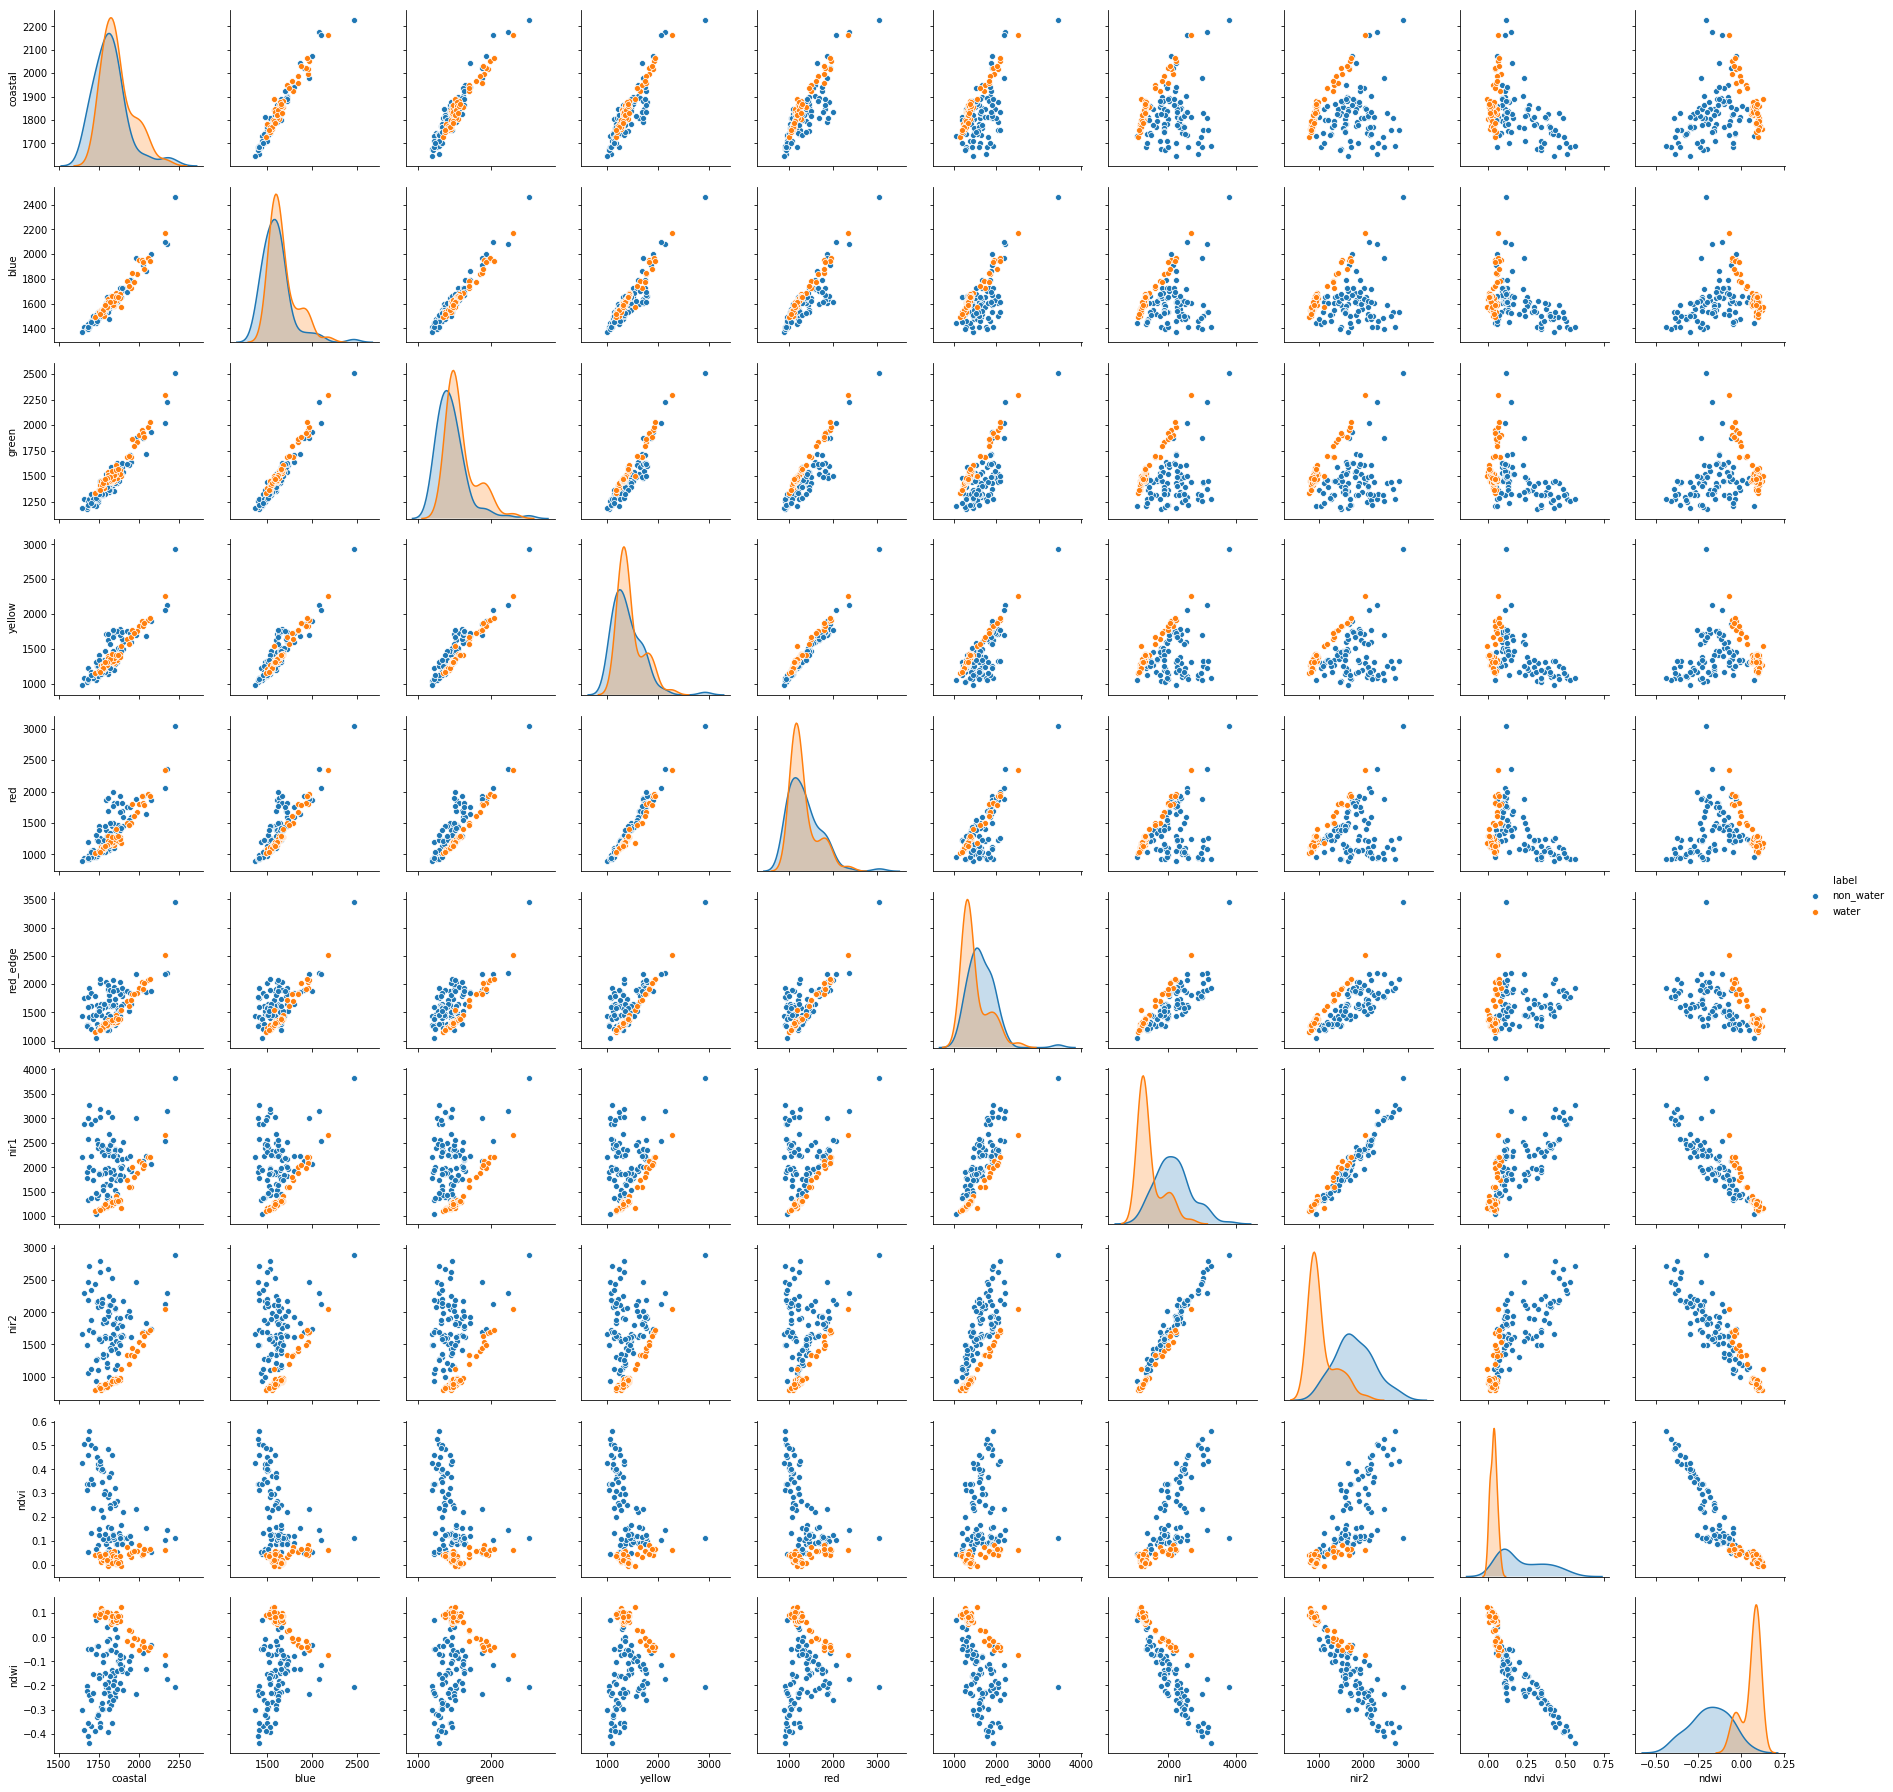

In [21]:
# Create scatterplot coloured per label

sb.pairplot(data_clean, hue='label')
;

/anaconda/envs/gbdx_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


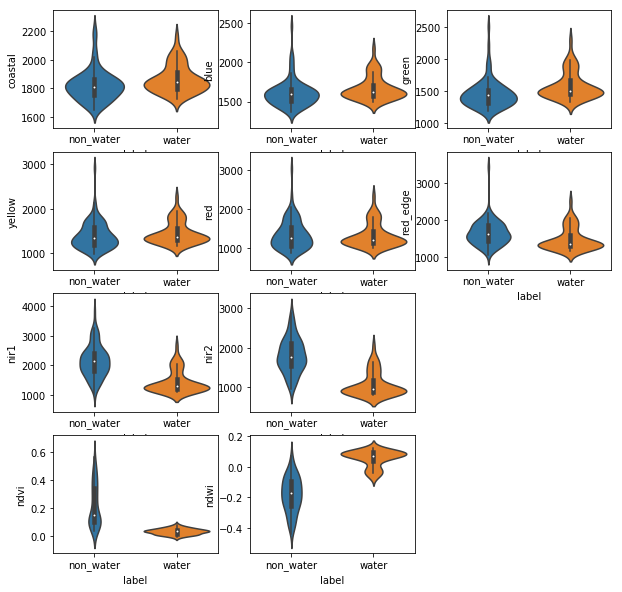

In [22]:
# Create violin plots per predictor

plt.figure(figsize=(10, 10))

for column_index, column in enumerate(data_clean.columns):
    if column == 'label':
        continue
    plt.subplot(4,3, column_index + 1)
    sb.violinplot(x='label', y=column, data=data_clean)

**Step 6: Classifier testing**

In this part we start modeling. We split the data into training and testing sets.

- A training set is a random subset of the data that we use to train our models.
- A testing set is a random subset of the data (mutually exclusive from the training set) that we use to validate our models on unforseen data.

We test de following models:

- Basic decision tree
- Random forest
- Naive bayes
- XGBoost

In [23]:
# We're using all band measurements as inputs
# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists

# We can extract the data in this format from pandas like this:
X = data_clean[['coastal','blue', 'green','yellow', 'red','red_edge','nir1','nir2','ndvi','ndwi']].values

# Similarly, we can extract the labels
y = data_clean['label'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the label in all_labels[5]

# Here's what a subset of our inputs looks like:
X[:5]

array([[ 1.83000000e+03,  1.58900000e+03,  1.43700000e+03,
         1.25800000e+03,  1.12200000e+03,  1.88400000e+03,
         3.02200000e+03,  2.53600000e+03,  4.58494208e-01,
        -3.55460866e-01],
       [ 1.85200000e+03,  1.61900000e+03,  1.43400000e+03,
         1.30000000e+03,  1.22200000e+03,  1.65400000e+03,
         2.37100000e+03,  2.04600000e+03,  3.19788478e-01,
        -2.46254928e-01],
       [ 1.84900000e+03,  1.65700000e+03,  1.47200000e+03,
         1.39100000e+03,  1.41100000e+03,  1.73500000e+03,
         2.34400000e+03,  2.06500000e+03,  2.48468708e-01,
        -2.28511530e-01],
       [ 1.80400000e+03,  1.53500000e+03,  1.36700000e+03,
         1.14000000e+03,  1.10200000e+03,  1.47400000e+03,
         1.98300000e+03,  1.60200000e+03,  2.85575365e-01,
        -1.83880597e-01],
       [ 1.81000000e+03,  1.55600000e+03,  1.34100000e+03,
         1.20100000e+03,  1.06400000e+03,  1.61200000e+03,
         2.33100000e+03,  1.98200000e+03,  3.73195876e-01,
        -2.

In [24]:
# We need to make sure that no variables are strings, so we need to transform 

# Import LabelEncoder
from sklearn import preprocessing

# Creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
y_encoded=le.fit_transform(y)

print(y_encoded)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
# Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split          # If error pip install sklearn in terminal

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X, y_encoded, test_size=0.25, random_state=1)

**Decision tree classifier**

In [26]:
# Fit decision tree model

from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(X_train, y_train)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(X_test, y_test)

0.9142857142857143

What percentage of accuracy did the model achieve?

There's a catch: Depending on how our training and testing set was sampled, our model can achieve anywhere from 80% to 100% accuracy:

''

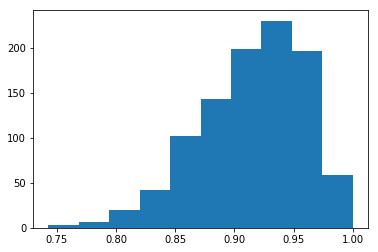

In [27]:
# Visualize possible model accuracies

model_accuracies = []

for repetition in range(1000):
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(X, y, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(X_train, y_train)
    classifier_accuracy = decision_tree_classifier.score(X_test, y_test)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
;

It's obviously a problem that our model performs quite differently depending on the subset of the data it's trained on. This phenomenon is known as overfitting: The model is learning to classify the training set so well that it doesn't generalize and perform well on data it hasn't seen before.

**Cross-validation**

This problem is the main reason that most data scientists perform k-fold cross-validation on their models: Split the original data set into k subsets, use one of the subsets as the testing set, and the rest of the subsets are used as the training set. This process is then repeated k times such that each subset is used as the testing set exactly once.

10-fold cross-validation is the most common choice, so let's use that here. Performing 10-fold cross-validation on our data set looks something like this:

(each square is an entry in our data set)

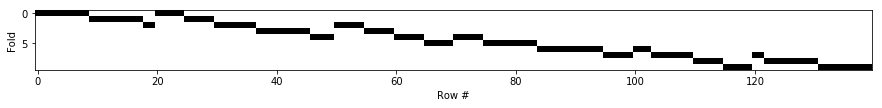

In [28]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), X, y)


We can perform 10-fold cross-validation on our model with the following code:

''

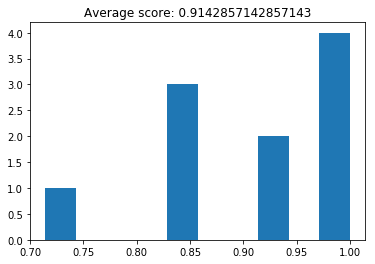

In [29]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

**Parameter tuning**
Every Machine Learning model comes with a variety of parameters to tune, and these parameters can be vitally important to the performance of our classifier. For example, if we severely limit the depth of our decision tree classifier:

''

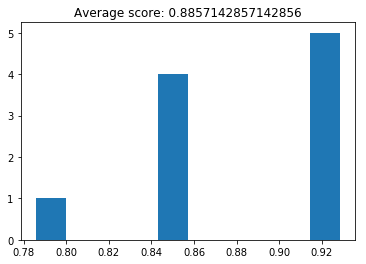

In [30]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

the classification accuracy falls tremendously.

Therefore, we need to find a systematic method to discover the best parameters for our model and data set.

The most common method for model parameter tuning is Grid Search. The idea behind Grid Search is simple: explore a range of parameters and find the best-performing parameter combination. Focus your search on the best range of parameters, then repeat this process several times until the best parameters are discovered.

Let's tune our decision tree classifier. We'll stick to only two parameters for now, but it's possible to simultaneously explore dozens of parameters if we want.

In [31]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

dt_grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

dt_grid_search.fit(X, y)
print('Best score: {}'.format(dt_grid_search.best_score_))
print('Best parameters: {}'.format(dt_grid_search.best_params_))

Best score: 0.9428571428571428
Best parameters: {'max_depth': 3, 'max_features': 4}


Now let's visualize the grid search to see how the parameters interact.

''

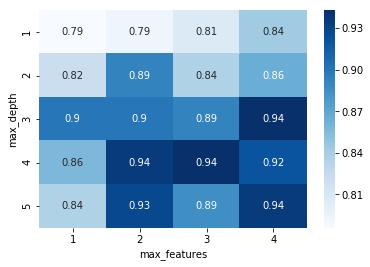

In [32]:
dt_grid_visualization = dt_grid_search.cv_results_['mean_test_score']
dt_grid_visualization.shape = (5, 4)
sb.heatmap(dt_grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, dt_grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, dt_grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

Let's go ahead and use a broad grid search to find the best settings for a handful of parameters.

In [33]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

dt_grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

dt_grid_search.fit(X, y)
print('Best score decision tree: {}'.format(dt_grid_search.best_score_))
print('Best parameters decision tree: {}'.format(dt_grid_search.best_params_))

Best score decision tree: 0.9428571428571428
Best parameters decision tree: {'criterion': 'gini', 'max_depth': 4, 'max_features': 3, 'splitter': 'best'}


In [34]:
# Classification report decision tree classifier

from sklearn.metrics import classification_report

y_pred = dt_grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   non_water       1.00      1.00      1.00        23
       water       1.00      1.00      1.00        12

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



In [35]:
# Confusion matrix decision tree classifier

from sklearn.metrics import confusion_matrix

y_pred = dt_grid_search.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[23  0]
 [ 0 12]]


**Random forest classifier**

In [36]:
# Fit random forest classifier

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

rf_grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

rf_grid_search.fit(X, y)
print('Best score random forest classifier: {}'.format(rf_grid_search.best_score_))
print('Best parameters random forest classifier: {}'.format(rf_grid_search.best_params_))

rf_grid_search.best_estimator_

Best score random forest classifier: 0.9714285714285714
Best parameters random forest classifier: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 25}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
# Classification report random forest classifier

from sklearn.metrics import classification_report

y_pred = rf_grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   non_water       1.00      1.00      1.00        23
       water       1.00      1.00      1.00        12

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



In [38]:
# Confusion matrix random forest classifier

from sklearn.metrics import confusion_matrix

y_pred = rf_grid_search.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[23  0]
 [ 0 12]]


**Naive Bayes classifier**

In [39]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Classifier 
naive_bayes_classifier = GaussianNB()

# Train the model using the training sets
naive_bayes_classifier.fit(X_train,y_train)

# Predict Output
y_pred= naive_bayes_classifier.predict(X_test)

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
from sklearn.metrics import accuracy_score

naive_bayes_classifier_accuracy = accuracy_score(y_test, y_pred)
print(naive_bayes_classifier_accuracy)

0.9142857142857143


In [40]:
# Classification report naive bayes classifier

from sklearn.metrics import classification_report

y_pred = naive_bayes_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   non_water       0.95      0.91      0.93        23
       water       0.85      0.92      0.88        12

    accuracy                           0.91        35
   macro avg       0.90      0.91      0.91        35
weighted avg       0.92      0.91      0.92        35



In [41]:
# Confusion matrix naive bayes classifier

from sklearn.metrics import confusion_matrix

y_pred = naive_bayes_classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[21  2]
 [ 1 11]]


**XGBoost classifier**

In [42]:
# Create the Xgboost specific DMatrix data format from the numpy array

import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=X,label=y_encoded)

In [43]:
# Fit XGBoost classifier

from sklearn.metrics import accuracy_score

xgboost_classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgboost_classifier.fit(X_train, y_train)

y_pred = xgboost_classifier.predict(X_test)

xgboost_classifier_accuracy = accuracy_score(y_test, y_pred)
print(xgboost_classifier_accuracy)

XGBoostError: value 0 for Parameter num_class should be greater equal to 1

In [ ]:
parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

xgb_grid_search = GridSearchCV(xgboost_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

xgb_grid_search.fit(X, y)
print('Best score xgboost classifier: {}'.format(xgb_grid_search.best_score_))
print('Best parameters xgboost classifier: {}'.format(xgb_grid_search.best_params_))

xgb_grid_search.best_estimator_

In [ ]:
# Classification report XGBoost classifier

from sklearn.metrics import classification_report

y_pred = xgboost_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix XGBoost classifier

from sklearn.metrics import confusion_matrix

y_pred = xgboost_classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))

**Compare performance of classifiers**

In [ ]:
# Summary of model results

print('Best score decision tree: {}'.format(dt_grid_search.best_score_))
print('Best parameters decision tree: {}'.format(dt_grid_search.best_params_))

print('Best score random forest: {}'.format(rf_grid_search.best_score_))
print('Best parameters random forest: {}'.format(rf_grid_search.best_params_))

print('Best score naive bayes:'.format(naive_bayes_classifier_accuracy))

print('Best score xgboost: {}'.format(xgb_grid_search.best_score_))

In [ ]:
# Compare performance classifiers

random_forest_classifier = rf_grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, X, y, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, X, y, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

**Step 7: Classification**

In this part we'll use the classifier with the highest accuracy to classify our satellite image. 

In [44]:
rf_grid_search.predict(X)

array(['non_water', 'non_water', 'non_water', 'non_water', 'non_water',
       'non_water', 'non_water', 'non_water', 'non_water', 'non_water',
       'non_water', 'non_water', 'non_water', 'non_water', 'non_water',
       'non_water', 'non_water', 'non_water', 'non_water', 'non_water',
       'water', 'water', 'water', 'water', 'water', 'water', 'water',
       'water', 'water', 'water', 'non_water', 'non_water', 'non_water',
       'non_water', 'non_water', 'non_water', 'non_water', 'non_water',
       'non_water', 'non_water', 'non_water', 'non_water', 'non_water',
       'non_water', 'non_water', 'non_water', 'non_water', 'non_water',
       'non_water', 'non_water', 'water', 'water', 'water', 'water',
       'water', 'water', 'water', 'water', 'water', 'water', 'non_water',
       'non_water', 'non_water', 'non_water', 'non_water', 'non_water',
       'non_water', 'non_water', 'non_water', 'non_water', 'water',
       'water', 'water', 'water', 'water', 'water', 'water', 'water',


  taken on 2018-09-13T03:30:42.179Z


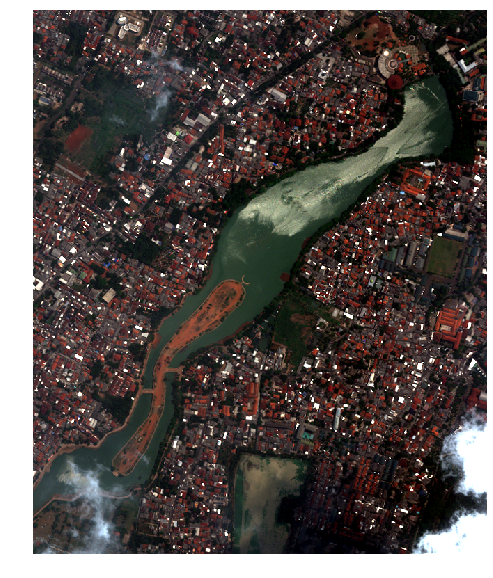

In [47]:
# Import image of Amsterdam and convert image to UTM projection

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1030010085B5FC00')
bbox = env.inputs.get('bbox', '106.81642055511476, -6.350359691139068, 106.82757854461671, -6.336966782499579')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))

print("  taken on {}".format( image.metadata["image"]["acquisitionDate"]))


image.plot(w=10, h=10)

# Transform dask array to array
image_array = image.read()
data = image_array

In [79]:
# Split image data into band layers

coastal = data[0]
blue = data[1]
green = data[2]
yellow = data[3]
red = data[4]
red_edge = data[5]
nir1 = data[6]
nir2 = data[7]


# Calculate indices

ndvi = (data[6] - data[4])/(data[6] + data[4])
ndwi = (data[2] - data[6]) / (data[2] + data[6])


# Create function that reshapes numpy arrays

def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

# Make sure ndvi and ndwi are stackable with band data by making them 3-dimensional (1,x,y)
ndvi = reshape(ndvi)
ndwi = reshape(ndwi)


# Stack arrays in sequence vertically (row wise)

image_array = np.vstack([data,ndvi,ndwi])

In [80]:
# Calculate 3-dimensional shape of new image_array
n_bands, rows, cols = image_array.shape

# Calculate number of pixels/samples
n_samples = rows*cols

# Create table where every row represents the data in one pixel/sample
reshaped_data = image_array.reshape(n_bands,(rows*cols))

#Remove NAN values
reshaped_data[np.isnan(reshaped_data)] = 0

In [81]:
# Predict class of image
result = rf_grid_search.predict(reshaped_data.T)
classification = result.T.T.T.reshape((rows, cols))

In [82]:
# Get classnames and corresponding indices
classnames, indices = np.unique(classification, return_inverse=True)

print(classnames)
print(np.unique(indices))

['non_water' 'water']
[0 1]


In [83]:
classification_plot = indices.reshape((rows, cols))

classification_plot = classification_plot + 1

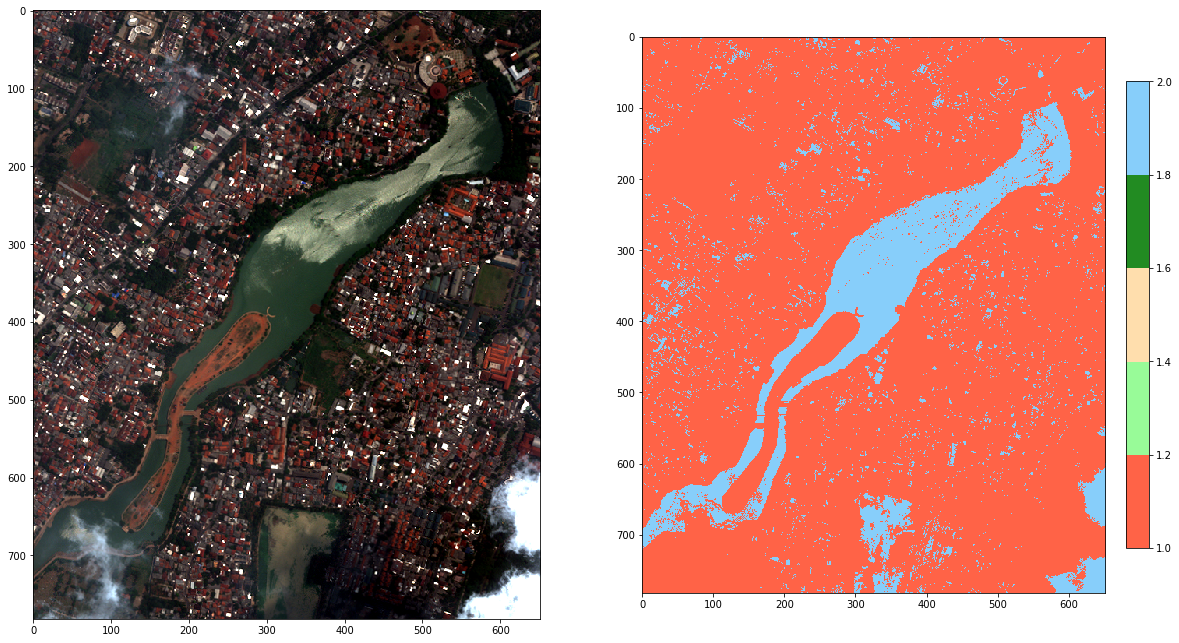

In [84]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
from matplotlib import colors

f = plt.figure( figsize = (20,20))

f.add_subplot(1, 2, 1)
plt.imshow(image.rgb())
f.add_subplot(1, 2, 2)
cmap = colors.ListedColormap(['tomato', 'palegreen', 'navajowhite', 'forestgreen', 'lightskyblue'])
im = plt.imshow(classification_plot,cmap)

plt.colorbar(im,fraction=0.046, pad=0.04)





#cmap = colors.ListedColormap(['red', 'limegreen', 'dimgrey', 'green', 'blue'])
        
#f2, ax = plt.subplots( figsize = (10,10))

#cax = ax.imshow(classification_plot, cmap=cmap, vmin=0, vmax=5)

#cbar = f2.colorbar(cax, ticks=[1, 2, 3, 4, 5])
#cbar.ax.set_xticklabels(['building', 'grass', 'street', 'tree', 'water'])

In [103]:
import itertools

# Shapely and Rasterio for processing geometries
from shapely import geometry
from shapely.geometry import box, shape, Polygon
from shapely.ops import cascaded_union
from rasterio import features   

# GBDX
from gbdxtools import Interface

# array operations and plotting
import numpy as np
import matplotlib.pyplot as plt

# scikit-image modules for image science operators
from skimage import filters, morphology

# Initialize gbdx interface
gbdx = Interface()

In [85]:

classification_plot[classification_plot == 1] = 0
classification_plot[classification_plot == 2] = 1

In [123]:
# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 50000.

# From the image metadata, we can determine the area of a single grid cell
cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')

50000.0 sq. m
13763 grid cells


In [124]:
# First, remove the small holes
water_cleaned = morphology.remove_small_holes(classification_plot, min_feature_size_cells)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

In [125]:
# Also extract the visible color (i.e., Red-Green-Blue) bands, which we'll use for side-by-side plotting as we proceed
rgb = image.rgb()

Text(0.5, 1.0, 'Cleaned Water Mask')

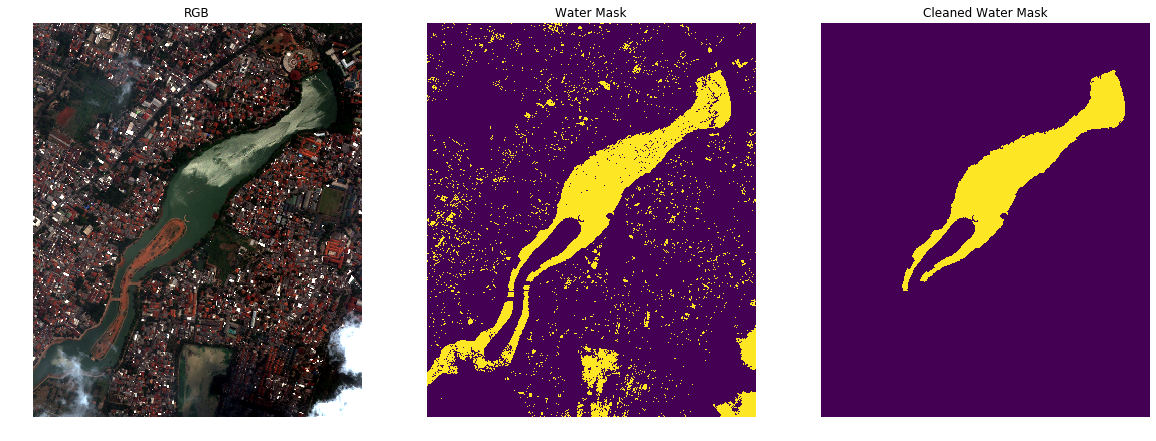

In [126]:
# View the results
plt.figure(figsize=(20,15))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(rgb)
plt.title("RGB")

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(classification_plot, vmin=0, vmax=1)
plt.title("Water Mask")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(water_cleaned, vmin=0, vmax=1)
plt.title("Cleaned Water Mask")

In [127]:
def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = [g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 


In [128]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = image.affine)

# Run a basic simplification algorithm to smooth the lines
water_lines_smooth = [g.simplify(image.affine.a) for g in water_lines]
    
# Finally, take a look at them on a slippy map
c = gbdx.vectors.map([{'geometry':x.__geo_interface__} for x in water_lines_smooth])

<IPython.core.display.Javascript object>

In [51]:
f.savefig('Classification_Jakarta.png')

In [61]:
import folium

In [62]:
bbox_list_str = bbox.split(',')

float(bbox_list_str[1])

52.32857221495543

In [63]:
bbox = [float(bbox_list_str[0]),float(bbox_list_str[1]),float(bbox_list_str[2]),float(bbox_list_str[3])]
trees = classification_plot == 2

In [ ]:
m = folium.Map([(bbox[1] + bbox[3])/2, (bbox[0] + bbox[2])/2],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB', name = 'cartocdn')

folium.raster_layers.ImageOverlay(
    image=image.rgb(),
    name='image 2017',
    bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
    opacity=1,
    interactive=False,
    cross_origin=False,
    zindex=1, 
    colormap=lambda x: (0,0,0, x)
).add_to(m)

folium.raster_layers.ImageOverlay(
    image=classification_plot,
    name='Classification 2017',
    bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
    opacity=1,
    interactive=False,
    cross_origin=False,
    zindex=1, 
    colormap=lambda x: (0,x,x, 1)
).add_to(m)



# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point], popup=df['ActualDBH'][point], group  = "Tree removals").add_to(m)

folium.LayerControl().add_to(m)

In [ ]:
m.save('classification_trees_2017_v2_pansharpen.html')

In [ ]:
m